In [461]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly
# import numpy as np

# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import Ridge
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.ensemble import RandomForestRegressor

pcos = pd.read_csv('pcos_dataset.csv')

#Splitting out the features for future ease
features = ["Age", "BMI", "Menstrual_Irregularity", "Testosterone_Level(ng/dL)", "Antral_Follicle_Count"]
categorical_features = ["Menstrual_Irregularity"]
numerical_features = ["Age", "BMI", "Testosterone_Level(ng/dL)", "Antral_Follicle_Count"]
target_variable = "PCOS_Diagnosis"

#explorng the dataset:
print("Shape of pcos dataframe: " + str(pcos.shape) + "\n")
pcos.head()

Shape of pcos dataframe: (1000, 6)



,Age,BMI,Menstrual_Irregularity,Testosterone_Level(ng/dL),Antral_Follicle_Count,PCOS_Diagnosis
0,24,34.7,1,25.2,20,0
1,37,26.4,0,57.1,25,0
2,32,23.6,0,92.7,28,0
3,28,28.8,0,63.1,26,0
4,25,22.1,1,59.8,8,0


In [462]:
#checking potential categorical values: 
for col in ["Menstrual_Irregularity", "Antral_Follicle_Count", "PCOS_Diagnosis", "Age"]: 
    print(pcos[col].unique())

#setting some to categorical: 
pcos['Menstrual_Irregularity'] = pcos['Menstrual_Irregularity'].astype('category')
pcos['PCOS_Diagnosis'] = pcos['PCOS_Diagnosis'].astype('category')


[1 0]
[20 25 28 26  8  6 29 17  5 21 11 13 23 14 18 10 22  7 24 19 15 12 27  9
 16]
[0 1]
[24 37 32 28 25 38 43 36 40 41 21 20 39 19 29 23 45 18 42 34 44 27 33 22
 26 35 31 30]


In [463]:
pcos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Age                        1000 non-null   int64   
 1   BMI                        1000 non-null   float64 
 2   Menstrual_Irregularity     1000 non-null   category
 3   Testosterone_Level(ng/dL)  1000 non-null   float64 
 4   Antral_Follicle_Count      1000 non-null   int64   
 5   PCOS_Diagnosis             1000 non-null   category
dtypes: category(2), float64(2), int64(2)
memory usage: 33.6 KB


In [464]:
#Checking for missing values:
pcos.isna().sum()

Age                          0
BMI                          0
Menstrual_Irregularity       0
Testosterone_Level(ng/dL)    0
Antral_Follicle_Count        0
PCOS_Diagnosis               0
dtype: int64

In [465]:
#checking for negative values where there shouldn't be any:
pcos.describe()

,Age,BMI,Testosterone_Level(ng/dL),Antral_Follicle_Count
count,1000.000000,1000.00000,1000.000000,1000.000000
mean,31.771000,26.38700,60.159500,17.469000
std,8.463462,4.93554,23.160204,7.069301
min,18.000000,18.10000,20.000000,5.000000
25%,24.000000,21.90000,41.700000,12.000000
50%,32.000000,26.40000,60.000000,18.000000
75%,39.000000,30.50000,80.300000,23.250000
max,45.000000,35.00000,99.800000,29.000000


## Exploring the data

We first plotted the distribution of all features, including the target feature PCOS_Diagnosis. These plots can give an indication of any potential class imbalance, or outliers in the dataset. 

We see that the target variable seems to be very imbalanced, because 80% of the dataset does not have a PCOS diagnosis. We will need to consider before using any machine learning models on the data and we will describe how we do that in the preprocessing section later in the report. 


In [466]:
import plotly.graph_objects as go
from  plotly.subplots import make_subplots
fig = make_subplots(2,3, shared_yaxes=False)

# fig, axes = plt.subplots(2,3,figsize=(12,12))
i = 1
j = 1
figures = []

# fig = px.histogram(pcos, x=col, nbins=60, color="PCOS_Diagnosis")

for feature in numerical_features: 
    figure = px.histogram(pcos, x=feature, color="PCOS_Diagnosis", text_auto=True)
    figures.append(figure)
    fig.add_trace(figure.data[0], row=i, col=j)
    fig.update_xaxes(title = feature, row=i, col=j)
    if j == 3:
        i = 2
        j = 1
    else:
        j += 1

figure = px.bar(pcos, x=categorical_features[0], pattern_shape=target_variable)
figures.append(figure)
fig.add_trace(figure.data[0], row=i, col=j)
fig.update_xaxes(title = categorical_features[0], row=i, col=j)

figure = px.bar(pcos, x=target_variable)
figures.append(figure)
fig.add_trace(figure.data[0], row=i, col=j+1)
fig.update_xaxes(title = target_variable, row=i, col=j+1)

fig.show()

# for figure in figures:
#     fig.add_trace()

# sns.histplot(pcos, x="PCOS_Diagnosis", binwidth=1, ax=axes[1,2])
# plt.show()

Next we plot the distribution of all non-target features indicating in each graph the distribution of PCOS within this category. 

From these we see that indicators of PCOS can be BMI over 25, mentrual irregularity, testosterone levels above 40 and high follicle count. 

PCOS diagnosis seems to be quite evenly distributed across age groups. 

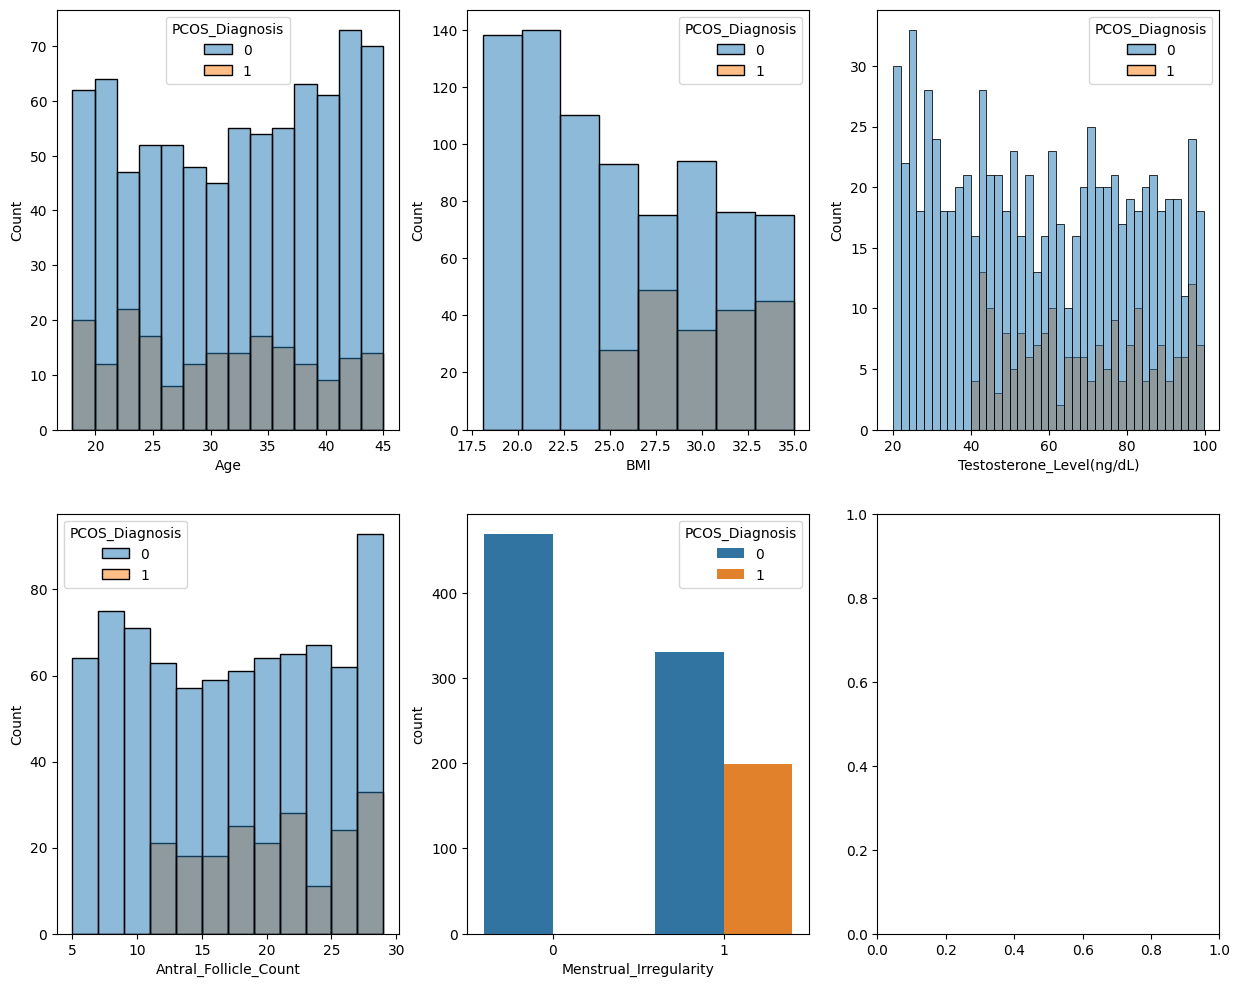

In [467]:

fig, axes = plt.subplots(2,3,figsize=(15,12))
i = 0
j = 0

for feature in numerical_features: 
    sns.histplot(pcos, x=feature, binwidth=2, ax=axes[j,i], hue="PCOS_Diagnosis")
    if i == 2:
        i = 0
        j = 1
    else:
        i += 1

sns.countplot(pcos, x=categorical_features[0], ax = axes[i,j], hue="PCOS_Diagnosis")
    
plt.show()

In [468]:
# col = "Testosterone_Level(ng/dL)"
# col = "Antral_Follicle_Count"
col = "BMI"
fig = px.histogram(pcos, x=col, nbins=4, color="PCOS_Diagnosis", text_auto=True)
fig.show()

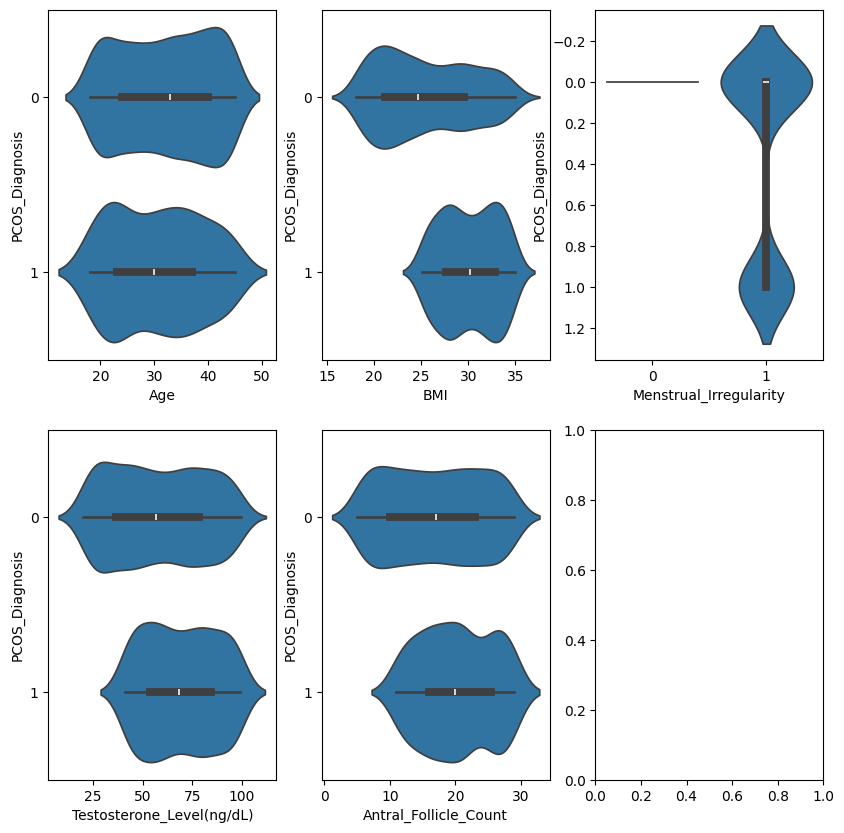

In [469]:
fig, axes = plt.subplots(2,3,figsize=(10,10))
i = 0
j = 0

for feature in features: 
    sns.violinplot(pcos, x=feature, y="PCOS_Diagnosis", ax=axes[j,i])
    if i == 2:
        i = 0
        j = 1
    else:
        i += 1
    
plt.show()

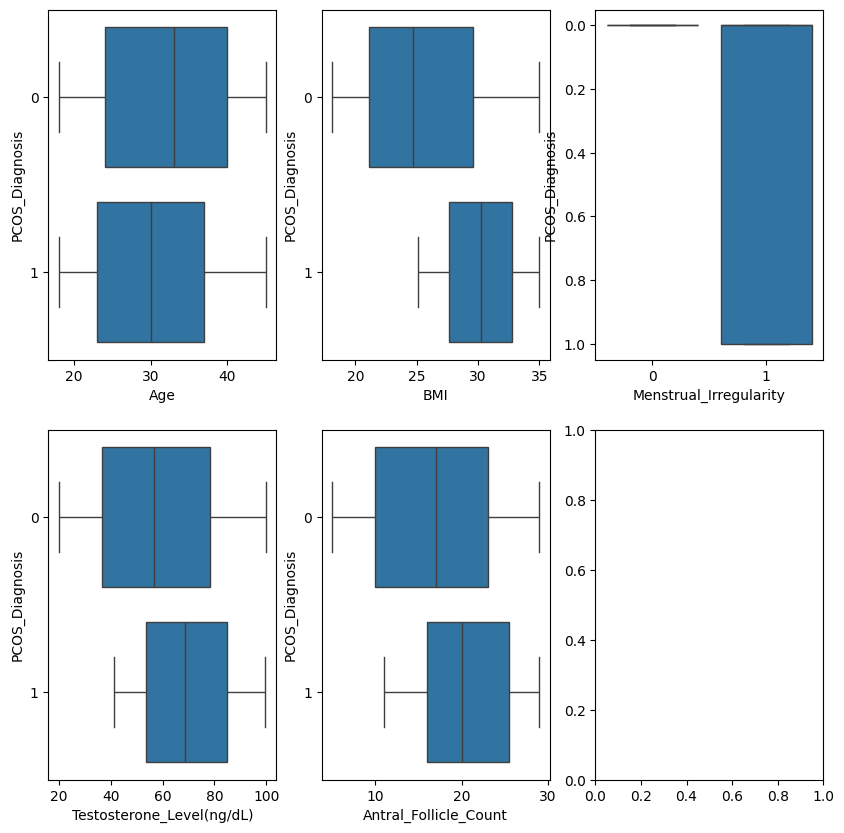

In [470]:
fig, axes = plt.subplots(2,3,figsize=(10,10))
i = 0
j = 0

for feature in features: 
    sns.boxplot(pcos, x=feature, y="PCOS_Diagnosis", ax=axes[j,i])
    if i == 2:
        i = 0
        j = 1
    else:
        i += 1
    
plt.show()

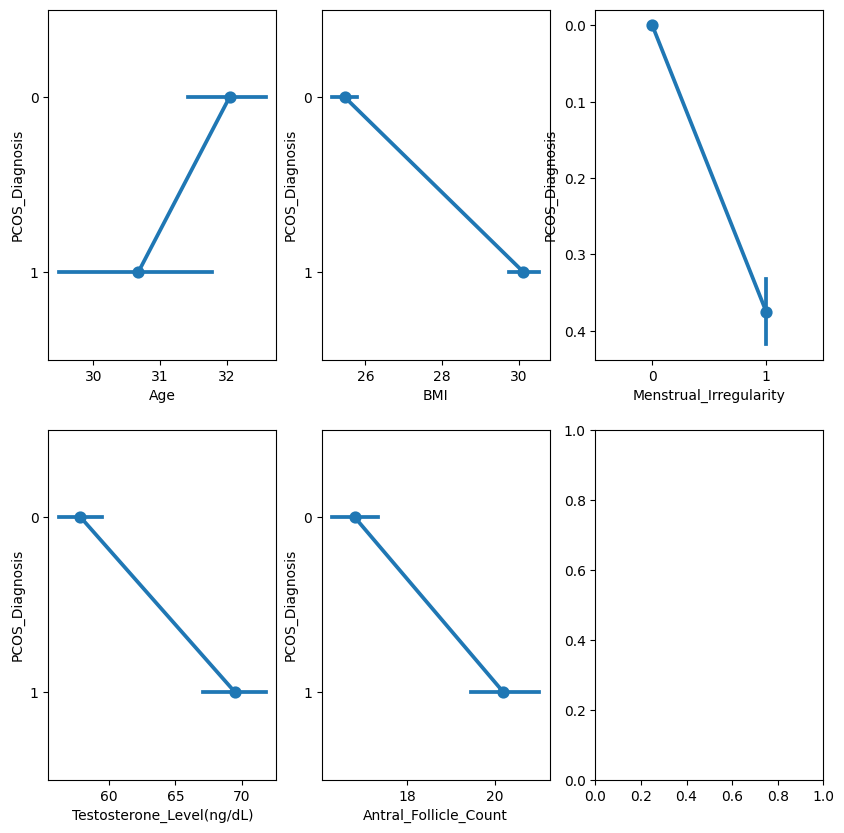

In [471]:
fig, axes = plt.subplots(2,3,figsize=(10,10))
i = 0
j = 0

for feature in features: 
    sns.pointplot(pcos, x=feature, y="PCOS_Diagnosis", ax=axes[j,i])
    if i == 2:
        i = 0
        j = 1
    else:
        i += 1
    
plt.show()

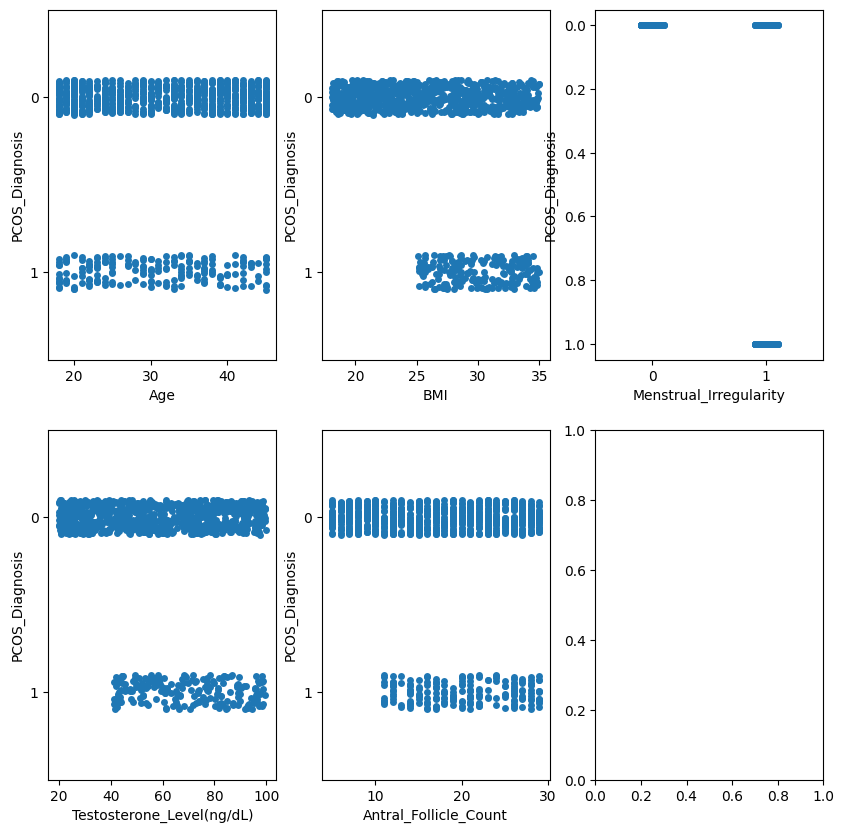

In [472]:
fig, axes = plt.subplots(2,3,figsize=(10,10))
i = 0
j = 0

for feature in features: 
    sns.stripplot(pcos, x=feature, y="PCOS_Diagnosis", ax=axes[j,i])
    if i == 2:
        i = 0
        j = 1
    else:
        i += 1
    
plt.show()

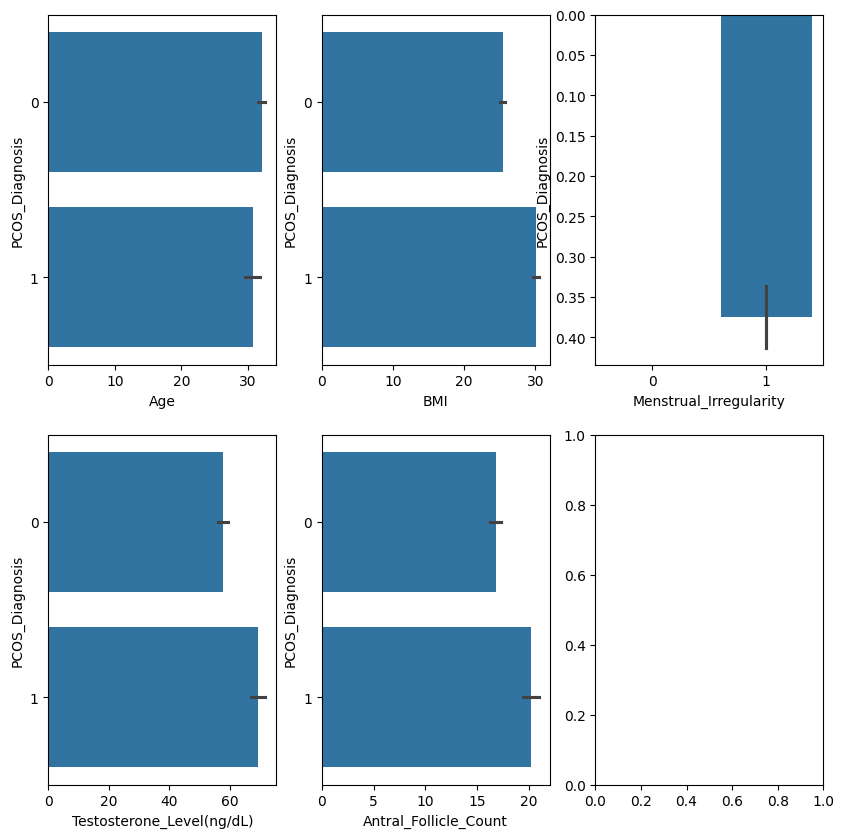

In [473]:
fig, axes = plt.subplots(2,3,figsize=(10,10))
i = 0
j = 0

for feature in features: 
    sns.barplot(pcos, x=feature, y="PCOS_Diagnosis", ax=axes[j,i])
    if i == 2:
        i = 0
        j = 1
    else:
        i += 1
    
plt.show()

The blow bar plots show what we also saw indicated in the visualizations above: that PCOS seems to be associated with higher levels of testsosterone, follicle count and BMI. It does not however seem to be associated with high age. 

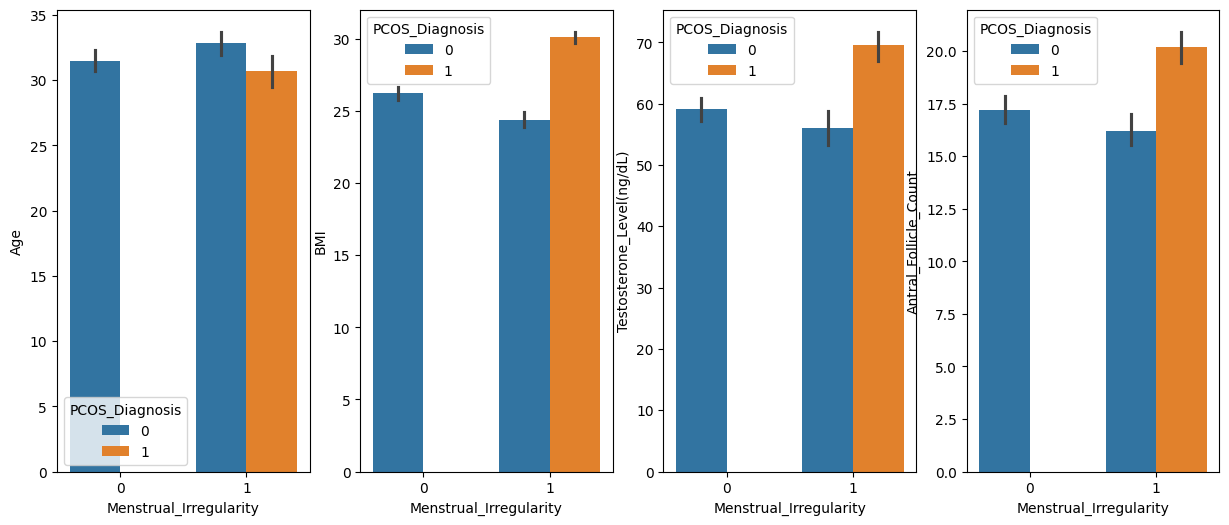

In [474]:
fig, axes = plt.subplots(1,4,figsize=(15,6))
# fig, axes = plt.subplots(1,4,figsize=(12,12))

i = 0

for feature in ["Age", "BMI", "Testosterone_Level(ng/dL)", "Antral_Follicle_Count"]:
    sns.barplot(pcos, x='Menstrual_Irregularity', y = feature, hue="PCOS_Diagnosis", ax=axes[i],)
    i +=1
    
plt.show()

## Preprocessing for modelling

This is a classification problem because the target variable, PCOS_Diagnosis, is categorical. Since the target variable can only assume two calues (0 or 1), this is a *binary* classification problem. 

The Logistic Regression model is optimized for binary classification, and we will choose this for our baseline model. 
For the comparison model, we will choose a tree model: DecicionTree.

Before we fit the machine learning models, we need to do some preprocessing steps on our data: 
- handle class imbalance
- scale the data as the units are not the same across the features
- split data into test and train data

In [475]:
#This cell can be removed in final report, just for readability while coding
pcos.head()

,Age,BMI,Menstrual_Irregularity,Testosterone_Level(ng/dL),Antral_Follicle_Count,PCOS_Diagnosis
0,24,34.7,1,25.2,20,0
1,37,26.4,0,57.1,25,0
2,32,23.6,0,92.7,28,0
3,28,28.8,0,63.1,26,0
4,25,22.1,1,59.8,8,0


In [476]:
y = pcos["PCOS_Diagnosis"]
X = pcos.drop("PCOS_Diagnosis", axis=1)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# scale the features:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns) 

#split dataset into train and test data set:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, 
    y, 
    test_size=0.2, 
    stratify=y)

## Baseline model: Ridge classifier

In [477]:
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import recall_score, f1_score, precision_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

ridge = RidgeClassifier(alpha=1) #initialize the model
ridge.fit(X_train, y_train) #fit with training data
y_pred_ridge = ridge.predict(X_test) #predict new data 

# print(ridge.score(X_test, y_pred_ridge))
ridge_coefs = ridge.coef_

print(classification_report(y_test, y_pred_ridge))
print(confusion_matrix(y_test, y_pred_ridge))
print("Accuracy: " + str(ridge.score(X_test, y_test))) # correct/total 
print("Precision: " + str(precision_score(y_test, y_pred_ridge)) ) #TP/(TP + FP)
print("Recall: " + str(recall_score(y_test, y_pred_ridge)) ) # TP/(TP+FN)
print("F1: " + str(f1_score(y_test, y_pred_ridge))) #harmonic mean of precision and recall

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       160
           1       0.96      0.60      0.74        40

    accuracy                           0.92       200
   macro avg       0.93      0.80      0.84       200
weighted avg       0.92      0.92      0.91       200

[[159   1]
 [ 16  24]]
Accuracy: 0.915
Precision: 0.96
Recall: 0.6
F1: 0.7384615384615385


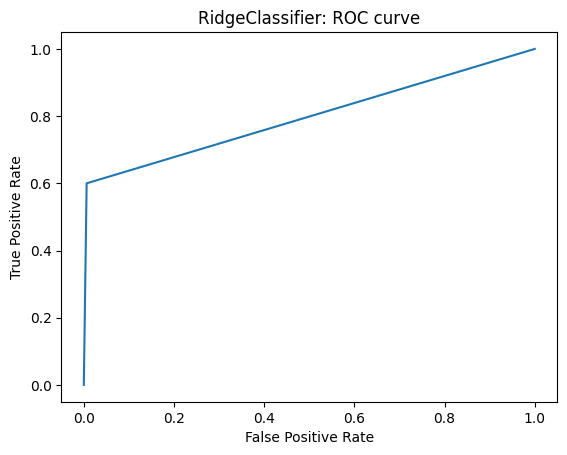

In [478]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_ridge)
plt.plot(fpr, tpr)
plt.title("RidgeClassifier: ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()


## Baseline model 2: Logistic Regression


In [479]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression() #initialize the model
logreg.fit(X_train, y_train) #fit with training data
y_pred_logreg = logreg.predict(X_test) #predict new data 

# print(ridge.score(X_test, y_pred_ridge))
logreg_coefs = logreg.coef_[0]

# print(classification_report(y_test, y_pred_logreg))

model_metrics = {
    "LogisticRegression": {
        "accuracy": ridge.score(X_test, y_test),
        "precision": precision_score(y_test, y_pred_logreg),
        "recall": recall_score(y_test, y_pred_logreg),
        "f1": f1_score(y_test, y_pred_logreg)
    }
}

logreg_confusion = confusion_matrix(y_test, y_pred_logreg)

# print(confusion_matrix(y_test, y_pred_logreg))
# print("Accuracy: " + str(ridge.score(X_test, y_test))) # correct/total 
# print("Precision: " + str(precision_score(y_test, y_pred_logreg)) ) #TP/(TP + FP)
# print("Recall: " + str(recall_score(y_test, y_pred_logreg)) ) # TP/(TP+FN)
# print("F1: " + str(f1_score(y_test, y_pred_logreg))) #harmonic mean of precision and recall

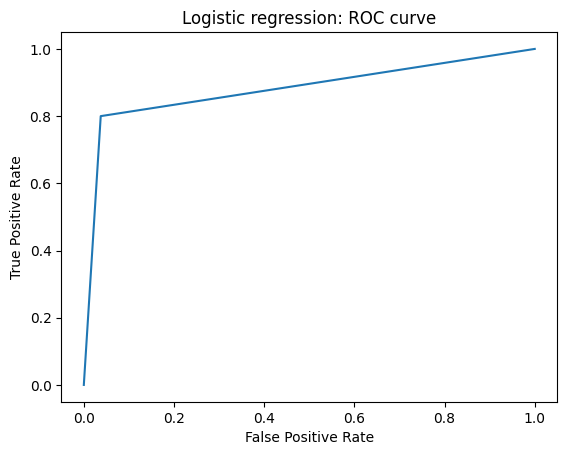

In [480]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_logreg)
plt.plot(fpr, tpr)
plt.title("Logistic regression: ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()


## Comparison model: Decision Tree:

In [ ]:
import numpy as np
from sklearn.metrics import root_mean_squared_error
from sklearn.tree import DecisionTreeClassifier


dt = DecisionTreeClassifier(
    max_depth=3 # 12 i randomly set, can use hyper parameter tuning to find a more optimal values
    )

dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
accuracy_dt = dt.score(X_test, y_test) #gives R_squared

print("Decision Tree R squared: " + str(accuracy_dt))

model_metrics["DecisionTree"] = {
        "accuracy": accuracy_dt,
        "precision": precision_score(y_test, y_pred_dt),
        "recall": recall_score(y_test, y_pred_dt),
        "f1": f1_score(y_test, y_pred_dt)
}

logreg_confusion = confusion_matrix(y_test, y_pred_logreg)

Decision Tree R squared: 0.97


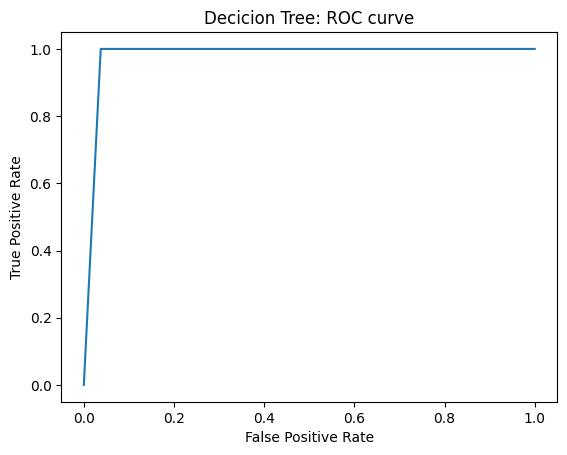

In [482]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_dt)
plt.plot(fpr, tpr)
plt.title("Decicion Tree: ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

Below is an overview of the metrics for both models. We see that the DecisionTree overall performs better, than logistic regression. 

In [483]:
print("Accuracy:")
for model in model_metrics.keys():
    print(model + ': ' + str(model_metrics[model]['accuracy']))
print('\n')

print("Precision:")
for model in model_metrics.keys():
    print(model + ': ' + str(model_metrics[model]['precision']))
print('\n')

print("Recall:")
for model in model_metrics.keys():
    print(model + ': ' + str(model_metrics[model]['recall']))
print('\n')

print("F1 score:")
for model in model_metrics.keys():
    print(model + ': ' + str(model_metrics[model]['f1']))

Accuracy:
LogisticRegression: 0.915
DecisionTree: 0.97


Precision:
LogisticRegression: 0.8421052631578947
DecisionTree: 0.8695652173913043


Recall:
LogisticRegression: 0.8
DecisionTree: 1.0


F1 score:
LogisticRegression: 0.8205128205128205
DecisionTree: 0.9302325581395349


## Important features in predicting PCOS

Using the decision tree model, we will find the most importan features in predicting a PCOS diagnosis.

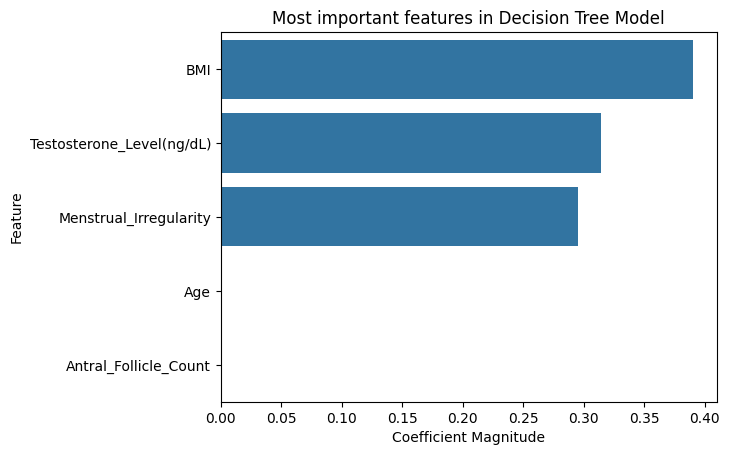

Index(['Age', 'BMI', 'Menstrual_Irregularity', 'Testosterone_Level(ng/dL)',
       'Antral_Follicle_Count'],
      dtype='object')
Logistic regression coefs: [-0.21181363  1.75231759  3.19073243  1.11223114  1.02665757]


In [484]:
dt_important_features = np.abs(dt.feature_importances_) # one weight for each column (including the "dummy columns")

# Create a DataFrame to pair features with importance
dt_df_feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': dt_important_features})
dt_df_feature_importance = dt_df_feature_importance.sort_values(by="Coefficient", ascending=False).reset_index(drop=True)

# print(dt_df_feature_importance.head())

dt_plot = sns.barplot(
    data=dt_df_feature_importance[:10][:],
    x = "Coefficient",
    y="Feature"
)

plt.xlabel("Coefficient Magnitude")
plt.ylabel("Feature")
plt.title("Most important features in Decision Tree Model")
plt.show()

print(X.columns)
print("Logistic regression coefs: " + str(logreg_coefs))